<a href="https://colab.research.google.com/github/pgalimanova/Galimyanova2_640-02/blob/main/osteoarthritis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
from google.colab import drive
!pip install torchmetrics
import torchmetrics
from torchmetrics import Precision, Recall, F1Score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 54.6 MB/s eta 0:00:00


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device}")

cuda


In [3]:
transform = transforms.Compose([
    transforms.Resize((128, 128)), #приведение к единому размеру
    transforms.ToTensor(), #преобразование в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #нормализация значений пикселей
])


In [4]:
BASE_PATH = "/content/drive/MyDrive/archive(1)"
TRAIN_PATH = os.path.join(BASE_PATH, "train/train")
VALID_PATH = os.path.join(BASE_PATH, "Valid/Valid")
TEST_PATH = os.path.join(BASE_PATH, "test/test")

print(f"Train exists: {os.path.exists(TRAIN_PATH)}")
print(f"Valid exists: {os.path.exists(VALID_PATH)}")
print(f"Test exists: {os.path.exists(TEST_PATH)}")
train_dataset = datasets.ImageFolder(root=TRAIN_PATH, transform=transform)
valid_dataset = datasets.ImageFolder(root=VALID_PATH, transform=transform)
test_dataset = datasets.ImageFolder(root=TEST_PATH, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #shuffle только на тренировочных данных
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

Train exists: True
Valid exists: True
Test exists: True


In [5]:
from functools import partial

class ResidualUnit(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        DefaultConv2d = partial(nn.Conv2d, kernel_size=3, stride=1, padding=1, bias=False)
         #основной путь residual unit: две свертки с batch norm и relu
        self.main_layer = nn.Sequential(
            DefaultConv2d(in_channels=in_channels, out_channels=out_channels, stride=stride),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            DefaultConv2d(in_channels=out_channels, out_channels=out_channels),
            nn.BatchNorm2d(out_channels)
        )
        #обходной путь
        if stride > 1:
            self.skip_connection = nn.Sequential(
                DefaultConv2d(in_channels=in_channels, out_channels=out_channels,
                            kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.skip_connection = nn.Identity()

    def forward(self, inputs): #сумма основного пути и обходного пути
        return F.relu(self.main_layer(inputs) + self.skip_connection(inputs))

class ResNet34(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        layers = [
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        ]

        prev_filters = 64
        for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
            stride = 1 if filters == prev_filters else 2 #использование stride=2 при изменении количества фильтров
            layers.append(ResidualUnit(prev_filters, filters, stride=stride))
            prev_filters = filters

        layers += [
            nn.AdaptiveAvgPool2d(output_size=1),
            nn.Flatten(),
            nn.Linear(512, num_classes)  #для 2 классов: Normal и Osteoarthritis
        ]

        self.resnet = nn.Sequential(*layers)

    def forward(self, inputs):
        return self.resnet(inputs)

model = ResNet34(num_classes=2).to(device)


In [6]:
#обучение
def train(model, optimizer, loss_fn, metric, train_loader, valid_loader, n_epochs):
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}

    for epoch in range(n_epochs):
        total_loss = 0.0 #сбрасываем счетчики для новой эпохи
        metric.reset()
        model.train()  #переводим модель в режим обучения

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch) #прямой проход
            loss = loss_fn(y_pred, y_batch)  #функция потерь

            total_loss += loss.item()
            loss.backward() #обратный проход
            optimizer.step() #обновляем веса модели
            optimizer.zero_grad() # #обнуляем градиенты

            metric.update(y_pred, y_batch)

        history["train_losses"].append(total_loss / len(train_loader))
        history["train_metrics"].append(metric.compute().item())
        history["valid_metrics"].append(evaluate_tm(model, valid_loader, metric).item())

        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}")

    return history
#валидация
def evaluate_tm(model, data_loader, metric):
  #режим оценки
    model.eval()
    metric.reset()
    with torch.no_grad():     #отключаем вычисление градиентов
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            metric.update(y_pred, y_batch)
    return metric.compute()

In [7]:
xentropy = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=2).to(device)

In [8]:
history = train(model, optimizer, xentropy, accuracy, train_loader, valid_loader, n_epochs=25)

Epoch 1/25, train loss: 0.7011, train metric: 0.6379, valid metric: 0.6630
Epoch 2/25, train loss: 0.5652, train metric: 0.6489, valid metric: 0.6724
Epoch 3/25, train loss: 0.5019, train metric: 0.7174, valid metric: 0.7566
Epoch 4/25, train loss: 0.4446, train metric: 0.7791, valid metric: 0.8081
Epoch 5/25, train loss: 0.4005, train metric: 0.8081, valid metric: 0.7816
Epoch 6/25, train loss: 0.3745, train metric: 0.8323, valid metric: 0.8627
Epoch 7/25, train loss: 0.3311, train metric: 0.8532, valid metric: 0.8970
Epoch 8/25, train loss: 0.2899, train metric: 0.8711, valid metric: 0.7644
Epoch 9/25, train loss: 0.2727, train metric: 0.8809, valid metric: 0.8877
Epoch 10/25, train loss: 0.2633, train metric: 0.8847, valid metric: 0.8440
Epoch 11/25, train loss: 0.2255, train metric: 0.9047, valid metric: 0.8487
Epoch 12/25, train loss: 0.1968, train metric: 0.9187, valid metric: 0.9376
Epoch 13/25, train loss: 0.1836, train metric: 0.9213, valid metric: 0.9314
Epoch 14/25, train lo

In [9]:
#тестирование
def test_model(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []

    test_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=2).to(device)
    test_accuracy.reset()

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            test_accuracy.update(y_pred, y_batch)

            _, predicted = torch.max(y_pred.data, 1) #индексы классов с максимальной вероятностью
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    final_accuracy = test_accuracy.compute()
    return final_accuracy, all_predictions, all_labels

test_accuracy, predictions, true_labels = test_model(model, test_loader)

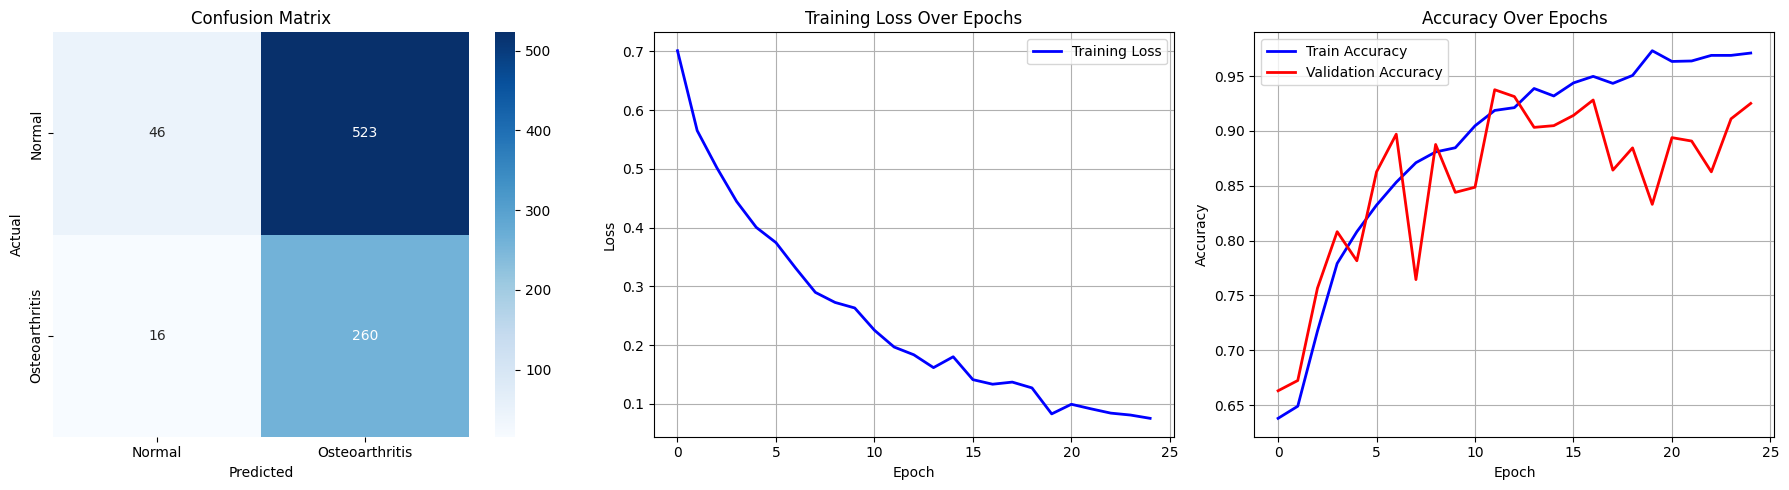

ОТЧЕТ:
                precision    recall  f1-score   support

        Normal     0.7419    0.0808    0.1458       569
Osteoarthritis     0.3321    0.9420    0.4910       276

      accuracy                         0.3621       845
     macro avg     0.5370    0.5114    0.3184       845
  weighted avg     0.6081    0.3621    0.2586       845



In [10]:
def plot_simple_results(true_labels, predictions, class_names):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # 1. матрица ошибок
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names, ax=ax1)
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')

    # 2. график функции потерь
    ax2.plot(history['train_losses'], 'b-', label='Training Loss', linewidth=2)
    ax2.set_title('Training Loss Over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    # 3. график точности
    ax3.plot(history['train_metrics'], 'b-', label='Train Accuracy', linewidth=2)
    ax3.plot(history['valid_metrics'], 'r-', label='Validation Accuracy', linewidth=2)
    ax3.set_title('Accuracy Over Epochs')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy')
    ax3.legend()
    ax3.grid(True)

    plt.tight_layout()
    plt.savefig('simple_results.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("ОТЧЕТ:")
    print(classification_report(true_labels, predictions,
                              target_names=class_names, digits=4))

plot_simple_results(true_labels, predictions, train_dataset.classes)

1. Матрица ошибок

- часто путает Normal с Osteoarthritis

- почти не путает Osteoarthritis с Normal

=> модель почти все снимки относит к категории патологии

2. График функции потерь

- loss постепенно снижается, обучение стабильное

- переобучения по loss не видно

3. График точности

- обе линии (train и validation) растут

- валидационная метрика колеблется, не превышая 90%

4. Статистика по классам

- для Normal — нормальная точность (74%), но очень низкое распознавание (8%)

- для Osteoarthritis — высокое распозанвание (94%), но низкая точность (33%)

=> модель хорошо распознает случаи остеоартрита, но почти не умеет распознавать норму; склонна ошибаться в пользу диагноза

=> лучший результат на 12 эпохе, к 25 эпохе переобучение модели!